# Introduction
There has been a strong pushback recently against vaccinations, particularly the MMR vaccine, which prevents measles, a disease with a basic reproduction number (R<sub>0</sub>) around 16. This high of an R<sub>0</sub> would wreak havoc on any classroom not properly vaccinated. The goal of this project was to determine and visualize the immunization rates across kindergarten classrooms in Utah, and how that rate was influenced by factors such as locale, location, and poverty rate. 

The data for this analysis came from the [Utah open data catalog](https://opendata.utah.gov/Health/Vaccinations-By-School-District-And-School-Utah-20/3nnk-8ku2), and the [National Center for Educational Statistics](https://nces.ed.gov/).

# 1 Load Data
## 1.1 Import Packages
For this project, I will analyze the data in a dataframe, so I will use pandas and numpy. Additoinally, I will use pyplot (from matplotlib) and seaborn for visualization tasks. 

In [1]:
#import necessary packages: pandas, numpy, pyplot, and seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1.2 Import Data
The bulk of the data for this analysis comes from a single CSV published by the Utah Open Data Catalog. I will read that CSV in using pandas, and give the columns more useful and descriptive names.

In [2]:
#import UDH kindergarten vaccination data csv into dataframe
ut_vax = pd.read_csv('utah_vax_by_school_district_2014.csv', header=0, names=['district', 'school', 'enrollment', 'num_exempt', 'num_fullvax', 'pct_fullvax', 'pct_MMR', 'pct_DTaP'])
ut_vax.district.astype('category');

# 2 Data Analysis
## 2.1 District-Level Herd Immunity Analysis
The first visualization I will do is of the immunication rates of classrooms in Utah's largest districts. For the purpose of completeness and comparison, I will also include charter and private schools in a separate column. I will prepresent this data as a swarm plot, which has all of the benefits of either a box plot or violin plot, but has the additional benefit of being able to identify individual data points, and see how they are distributed on a smaller scale basis.

I'll begin this process by creating a list of Utah's largest districts, and will filter the dataframe for districts that are in this list.

In [3]:
#create list of the largest districts in Utah, and create a dataframe containing the data for these districts
lg_dist = ['Alpine', 'Davis', 'Granite', 'Jordan', 'Canyons', 'Nebo', 'Weber', 'Washington', 'Salt Lake', 'Provo', 'Charter/private']
ut_vax_large = ut_vax[ut_vax.district.isin(lg_dist)]

ut_vax_large.head()

,district,school,enrollment,num_exempt,num_fullvax,pct_fullvax,pct_MMR,pct_DTaP
0,Alpine,Alpine Elementary,86,6,73,84.9,87.2,88.4
1,Alpine,Alpine Online School,12,3,7,58.3,83.3,91.7
2,Alpine,American Heritage School,66,6,60,90.9,90.9,90.9
3,Alpine,Aspen Elementary,68,3,65,95.6,95.6,95.6
4,Alpine,Barratt Elementary,76,5,70,92.1,96.1,92.1


I'll use seaborn to group these data by district, which will be both the x and color variable. I will also add in a line showing the immunization rate required for a classroom to have herd immunity. This will serve as a point of reference to see how many classrooms are at a problematic level of immunity. 

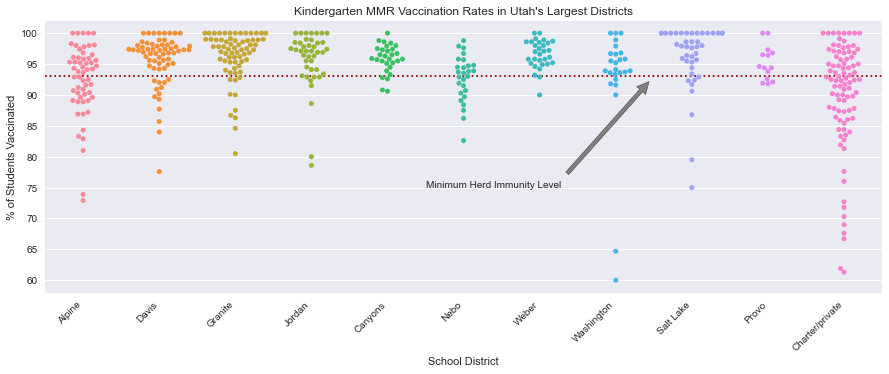

In [4]:
#create a swarm plot that shows the distribution of MMR immunization rates for the largest school districts in Utah
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.axhline(y=93, color='darkred', linestyle=':')
chart1 = sns.swarmplot(x='district', y='pct_MMR', data=ut_vax_large, order=lg_dist)
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=45, horizontalalignment='right')
chart1.set_title('Kindergarten MMR Vaccination Rates in Utah\'s Largest Districts')
chart1.set(xlabel='School District', ylabel='% of Students Vaccinated')
chart1.annotate('Minimum Herd Immunity Level', xy=[7.5, 93], xytext=(4.5, 75), arrowprops=dict(facecolor='grey', shrink=0.05));
plt.savefig('plot1.png', dpi=300, bbox_inches = "tight")

## 2.2 Locale-Based Herd Immunity Analysis
Next, I will show how immunization is distributed based on locale (e.g. urban, suburban, rural). To do this, I will need additional information on each school. The National Center for Educational Statistics provides locale and income data that will be of use in the coming visualizations. I'll scrape data on Utah's elementary schools from the NCES, and read that data into a new dataframe.

In order to merge these dataframes, I will need the school and district names to match. I will use regular expressions (regex) to cahnge the names of the schools in each dataframe, and maximize the likelihood of a match on both school and district.

In [5]:
#import csv containing NCES data for elementary schools in Utah.
ut_kinder = pd.read_csv('utah_k_schools.csv')

#to get names to match, drop 'Elementary' from vax table and 'School' from NCES table
ut_vax['name_short'] = ut_vax['school'].str.replace(r' Elementa.+', '')
ut_vax['name_short'] = ut_vax['name_short'].str.replace(r' Schoo.+', '')
ut_kinder['name_short'] = ut_kinder['school_name'].str.replace(r' Scho.+', '')
ut_kinder['district'] = ut_kinder['district'].str.replace(r' District', '')
ut_kinder['district'] = ut_kinder['district'].str.replace(r' City', '')

Now that the names of the schools and districts match, I will merge the two dataframes on both columns, and drop the dupicate informations. I will also fix the column names in the merged dataframe for consistency across columns. 

To provide a single income metric that is comparable across schools, I will calculate the precent of students who received free or reduced lunch. This number actually represents the whole school, not just the kindergarten, but I am going to assume that the number for the school at large is a decent representation of the kindergarten within that school.

In [6]:
#inner merge the UDH dataset with the NCES dataset
kinder_merge = pd.merge(ut_vax, ut_kinder, how='inner', on='name_short')
kinder_merge = kinder_merge.drop(['school', 'school_name'], axis=1)
kinder_merge[['free_lunch', 'reduced_lunch', 'students']]=kinder_merge[['free_lunch', 'reduced_lunch', 'students']].replace('?', np.nan)
kinder_merge['pct_freered'] = (kinder_merge['free_lunch'].astype(float) + kinder_merge['reduced_lunch'].astype(float))/kinder_merge['students'].astype(float) * 100

kinder_merge.head()

,district_x,enrollment,num_exempt,num_fullvax,pct_fullvax,pct_MMR,pct_DTaP,name_short,district_y,county_name,street_address,city,state,zip,locale,title_i,students,free_lunch,reduced_lunch,pct_freered
0,Alpine,86,6,73,84.9,87.2,88.4,Alpine,Alpine,Utah County,400 E 300 N,ALPINE,UT,84004,Suburb: Large,No,732,36,8,6.010929
1,Alpine,12,3,7,58.3,83.3,91.7,Alpine Online,Alpine,Utah County,575 N 100 E,AMERICAN FORK,UT,84003,Suburb: Large,No,140,9,1,7.142857
2,Alpine,68,3,65,95.6,95.6,95.6,Aspen,Alpine,Utah County,945 W 2000 N,OREM,UT,84057,City: Small,No,469,133,29,34.541578
3,Alpine,76,5,70,92.1,96.1,92.1,Barratt,Alpine,Utah County,168 N 900 E,AMERICAN FORK,UT,84003,Suburb: Large,No,543,53,35,16.206262
4,Alpine,138,13,114,82.6,89.1,89.9,Black Ridge,Alpine,Utah County,9358 N. Sunset Drive,EAGLE MOUNTAIN,UT,84005,Suburb: Large,No,1272,142,61,15.959119


I'll use a dictionary to assign colors based on the locale grouping, so all subgroups have the same coloring. Just as with the previous plot, I will again include a horzontal line showing herd immunity. This will allow readers to quickly see which locales are large above this line, and which are largely below. 

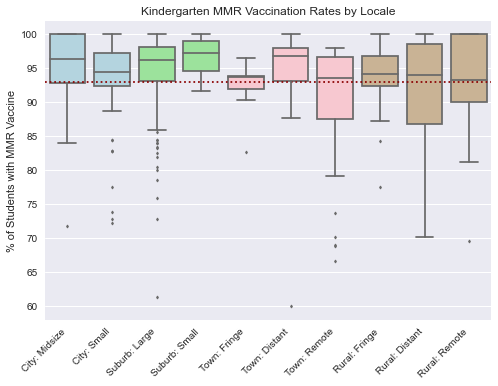

In [7]:
#create box plot for immunization rate distributions based on locale
colordict = {'City: Midsize':'lightblue', 'City: Small':'lightblue', 'Suburb: Large':'lightgreen', 'Suburb: Small':'lightgreen', 'Town: Fringe':'pink', 'Town: Distant':'pink', 'Town: Remote':'pink', 'Rural: Fringe':'tan', 'Rural: Distant':'tan', 'Rural: Remote':'tan'}
plt.axhline(y=93, color='darkred', linestyle=':')
chart2 = sns.boxplot(x='locale', y='pct_MMR', data=kinder_merge, order=['City: Midsize', 'City: Small', 'Suburb: Large', 'Suburb: Small', 'Town: Fringe', 'Town: Distant', 'Town: Remote', 'Rural: Fringe', 'Rural: Distant', 'Rural: Remote'], palette=colordict, fliersize=2);
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=45, horizontalalignment='right');
chart2.set(title='Kindergarten MMR Vaccination Rates by Locale', xlabel='', ylabel='% of Students with MMR Vaccine')
plt.savefig('plot2.png', dpi=300, bbox_inches = "tight")

## 2.3 Income-Based Immunity Analysis
The last two plots will show the impact that poverty level has on a school's immunity rate. The first way I will visualize this is with a scatter plot. Again, I will include a herd-immunity bar to allow readers to see the relative number of classrooms above and below this level. 

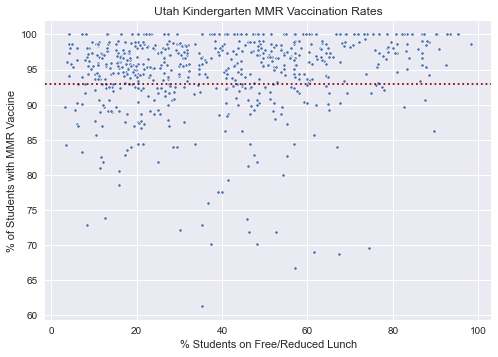

In [8]:
#scatter plot of pct_mmr vs pct_freered
plt.axhline(y=93, color='darkred', linestyle=':')
chart3 = sns.scatterplot(x='pct_freered', y='pct_MMR', data=kinder_merge, marker='.', palette=colordict)
chart3.set(title='Utah Kindergarten MMR Vaccination Rates', xlabel='% Students on Free/Reduced Lunch', ylabel='% of Students with MMR Vaccine')
plt.savefig('plot3.png', dpi=300, bbox_inches = "tight")

The last graph will show similar data as the previous graph, but it will specifically show the percentage of classrooms that have achieved herd immunity, binned by the percentage of students that receive free or reduced lunch. 

To do this, I will create a new dataframe, populated with data based on both the values from the original dataframe, as well as values from a filtered dataframe, which only containts information on classrooms that have achieved herd immunity. 

I'll plot this data in a histogram plot, binned in increments of 10%

In [9]:
#create boolean column stating whether the classroom is herd immune (pct_MMR >= 93)
kinder_merge['herd_immune'] = kinder_merge.pct_MMR >= 93

#create the bins for the histogram, and create an empty dataframe
hist_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
chart4_data= pd.DataFrame()

#populate dataframe with a for loop
for i in range(len(hist_bins)-1):
    chart4_data.loc[i, 'b_range'] = hist_bins[i]
    chart4_data.loc[i, 't_range'] = hist_bins[i + 1]
    chart4_data.loc[i, 'label'] = str(hist_bins[i])+'% to '+str(hist_bins[i+1])+'%'
    chart4_data.loc[i, 'count_herd_imm'] = kinder_merge[(kinder_merge.pct_freered >= hist_bins[i]) & (kinder_merge.pct_freered <= hist_bins[i + 1]) & (kinder_merge.herd_immune == True)].name_short.count()
    chart4_data.loc[i, 'count_total'] = kinder_merge[(kinder_merge.pct_freered >= hist_bins[i]) & (kinder_merge.pct_freered <= hist_bins[i + 1])].name_short.count()
    chart4_data.loc[i, 'pct_herd_imm'] = chart4_data.loc[i, 'count_herd_imm'] / chart4_data.loc[i, 'count_total'] * 100

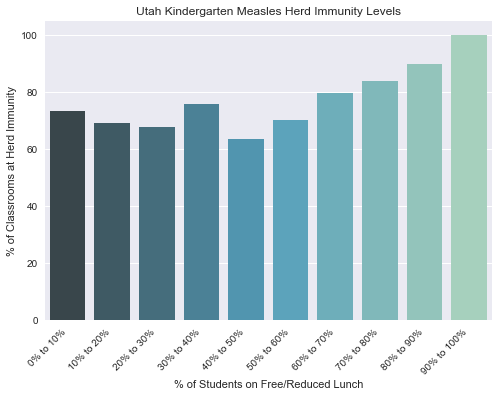

In [10]:
#create histogram showing the percentage of classrooms in each bin that are herd immune
chart4=sns.barplot(x='label', y='pct_herd_imm', data= chart4_data, palette='GnBu_d')
chart4.set_xticklabels(chart4.get_xticklabels(), rotation=45, horizontalalignment='right')
chart4.set(title='Utah Kindergarten Measles Herd Immunity Levels', xlabel='% of Students on Free/Reduced Lunch', ylabel='% of Classrooms at Herd Immunity')
plt.savefig('plot4.png', dpi=300, bbox_inches = "tight")

In [11]:
len(kinder_merge[kinder_merge['herd_immune']==True])/len(kinder_merge)

0.7211678832116788

# 3 Conclusions
The first visualization shows that herd immunity is not at all uniform across districts in Utah. Alpine Schoold District specifically has notably poor herd immunity rates. Even more extreme are private and charter schools, for which more than half of all kindergarten classrooms are not herd immune to measles.

The second graph shows that towns and rural areas have the largest group of classrooms that have not achieved herd immunity. However it also shows that this is a problem that spans all locales in Utah.

Lastly, the final two graphs showed that this is not a problem that particularly plagues poorer schools. Quite the opposite, this is a far larger problem in Utah's wealthier schools. Indeed, schools with free- or reduced-lunch rates between 90 and 100% have a perfect record for achieving herd immunity in their kindergarten classrooms. 